In [1]:
import sys
sys.path.append('..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import accuracy_score, precision_recall_curve
import warnings
warnings.filterwarnings('ignore')

from src.utils.data_loader import DataLoader
from src.models.embedding_model import EmbeddingModel, TopicMatchingEvaluator

C:\Users\Serkan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
cd ..

c:\Users\Serkan\Desktop\digitalpulse-opinion-analyzer


In [3]:
loader = DataLoader()
topics_df, conclusions_df, opinions_df = loader.load_all_data(clean=True)

print(f" Loaded {len(topics_df)} topics")
print(f" Loaded {len(opinions_df)} opinions")
print(f" Loaded {len(conclusions_df)} conclusions")

print("\n Sample Topic:")
print(f"ID: {topics_df.iloc[0]['topic_id']}")
print(f"Text: {topics_df.iloc[0]['text'][:150]}...")

print("\n Sample Opinion:")
print(f"Text: {opinions_df.iloc[0]['text'][:150]}...")
print(f"Type: {opinions_df.iloc[0]['type']}")
print(f"Topic ID: {opinions_df.iloc[0]['topic_id']}")

2025-10-21 20:10:58.590 | INFO     | src.utils.data_loader:_load_config:14 - Configuration loaded successfully from configs/config.yaml
2025-10-21 20:10:58.604 | INFO     | src.utils.data_loader:load_topics:27 - Topics data loaded successfully from data\topics_clean.csv
2025-10-21 20:10:58.619 | INFO     | src.utils.data_loader:load_conclusions:40 - Conclusions data loaded successfully from data\conclusions_clean.csv
2025-10-21 20:10:58.703 | INFO     | src.utils.data_loader:load_opinions:53 - Opinions data loaded successfully from data\opinions_clean.csv


 Loaded 4019 topics
 Loaded 26690 opinions
 Loaded 3351 conclusions

 Sample Topic:
ID: 007ACE74B050
Text: On my perspective, I think that the face is a natural landform because I dont think that there is any life on Mars. In these next few paragraphs, I'll...

 Sample Opinion:
Text: I think that the face is a natural landform because there is no life on Mars that we have descovered yet ...
Type: Claim
Topic ID: 007ACE74B050


In [ ]:
embedding_model = EmbeddingModel()

results = embedding_model.match_opinions_to_topics(
    topic_texts=topics_df['text'].tolist(),
    opinion_texts=opinions_df['text'].tolist(),
    opinion_ids=opinions_df.index.tolist()
)

2025-10-21 20:10:58.712 | INFO     | src.models.embedding_model:__init__:19 - Using device: cpu
2025-10-21 20:11:02.101 | INFO     | src.models.embedding_model:__init__:24 - Embedding dimension: 768
2025-10-21 20:11:02.705 | INFO     | src.models.embedding_model:_init_qdrant:36 - Qdrant connected successfully at localhost:6333
2025-10-21 20:11:02.705 | INFO     | src.models.embedding_model:_init_qdrant:37 - Existing collections: 1
2025-10-21 20:11:02.707 | INFO     | src.models.embedding_model:match_opinions_to_topics:112 - Matching 26690 opinions to 4019 topics
2025-10-21 20:11:02.708 | INFO     | src.models.embedding_model:_match_with_qdrant:117 - Using Qdrant for fast matching...
2025-10-21 20:11:02.708 | INFO     | src.models.embedding_model:_match_with_qdrant:119 - Encoding opinions...
2025-10-21 20:11:02.709 | INFO     | src.models.embedding_model:encode_texts:47 - Encoding 26690 texts with batch size 32
Batches:  59%|█████▉    | 494/835 [18:55<05:16,  1.08it/s] 


THRESHOLD OPTIMIZATION
Threshold: 0.00 | Accuracy: 0.0223 | Coverage: 100.00%
Threshold: 0.05 | Accuracy: 0.0223 | Coverage: 100.00%
Threshold: 0.10 | Accuracy: 0.0223 | Coverage: 100.00%
Threshold: 0.15 | Accuracy: 0.0223 | Coverage: 100.00%
Threshold: 0.20 | Accuracy: 0.0223 | Coverage: 100.00%
Threshold: 0.25 | Accuracy: 0.0223 | Coverage: 99.97%
Threshold: 0.30 | Accuracy: 0.0224 | Coverage: 99.78%
Threshold: 0.35 | Accuracy: 0.0225 | Coverage: 99.12%
Threshold: 0.40 | Accuracy: 0.0228 | Coverage: 97.47%
Threshold: 0.45 | Accuracy: 0.0232 | Coverage: 94.18%
Threshold: 0.50 | Accuracy: 0.0238 | Coverage: 89.08%
Threshold: 0.55 | Accuracy: 0.0246 | Coverage: 82.14%
Threshold: 0.60 | Accuracy: 0.0257 | Coverage: 72.79%
Threshold: 0.65 | Accuracy: 0.0274 | Coverage: 60.50%
Threshold: 0.70 | Accuracy: 0.0305 | Coverage: 46.30%
Threshold: 0.75 | Accuracy: 0.0353 | Coverage: 31.43%
Threshold: 0.80 | Accuracy: 0.0438 | Coverage: 17.01%
Threshold: 0.85 | Accuracy: 0.0596 | Coverage: 6.41%


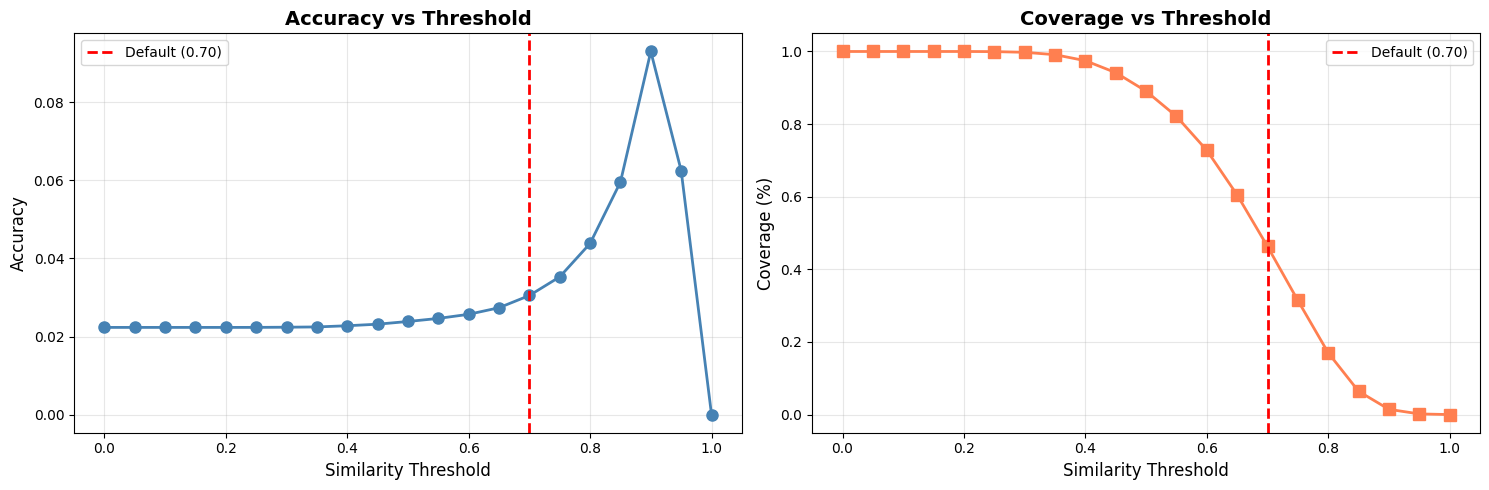

In [ ]:
print("\n" + "="*70)
print("THRESHOLD OPTIMIZATION")
print("="*70)

similarity_scores = np.array(results['similarity_scores'])
predicted_topics = np.array(results['matched_topic_ids'])
true_topics = np.array(opinions_df['topic_id'].tolist())

# Calculate accuracy for different thresholds
thresholds = np.arange(0.0, 1.05, 0.05)
accuracies = []
coverage = []

for threshold in thresholds:
    above_threshold = similarity_scores >= threshold
    
    if above_threshold.sum() == 0:
        acc = 0
        cov = 0
    else:
        acc = accuracy_score(
            true_topics[above_threshold],
            predicted_topics[above_threshold]
        )
        cov = above_threshold.sum() / len(above_threshold)
    
    accuracies.append(acc)
    coverage.append(cov)
    
    print(f"Threshold: {threshold:.2f} | Accuracy: {acc:.4f} | Coverage: {cov:.2%}")

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(thresholds, accuracies, marker='o', linewidth=2, markersize=8, color='steelblue')
axes[0].axvline(0.70, color='red', linestyle='--', linewidth=2, label='Default (0.70)')
axes[0].set_xlabel('Similarity Threshold', fontsize=12)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].set_title('Accuracy vs Threshold', fontsize=14, fontweight='bold')
axes[0].grid(alpha=0.3)
axes[0].legend()

axes[1].plot(thresholds, coverage, marker='s', linewidth=2, markersize=8, color='coral')
axes[1].axvline(0.70, color='red', linestyle='--', linewidth=2, label='Default (0.70)')
axes[1].set_xlabel('Similarity Threshold', fontsize=12)
axes[1].set_ylabel('Coverage (%)', fontsize=12)
axes[1].set_title('Coverage vs Threshold', fontsize=14, fontweight='bold')
axes[1].grid(alpha=0.3)
axes[1].legend()

plt.tight_layout()
plt.savefig('docs/threshold_optimization.png', dpi=300, bbox_inches='tight')
plt.show()

['007ACE74B050' '007ACE74B050' '233A9C9D748F' ... '4DC0660FD777'
 'BBDA39C84AF7' '9D0934987831'] ['007ACE74B050' '007ACE74B050' '007ACE74B050' ... 'FFA381E58FC6'
 'FFA381E58FC6' 'FFA381E58FC6']


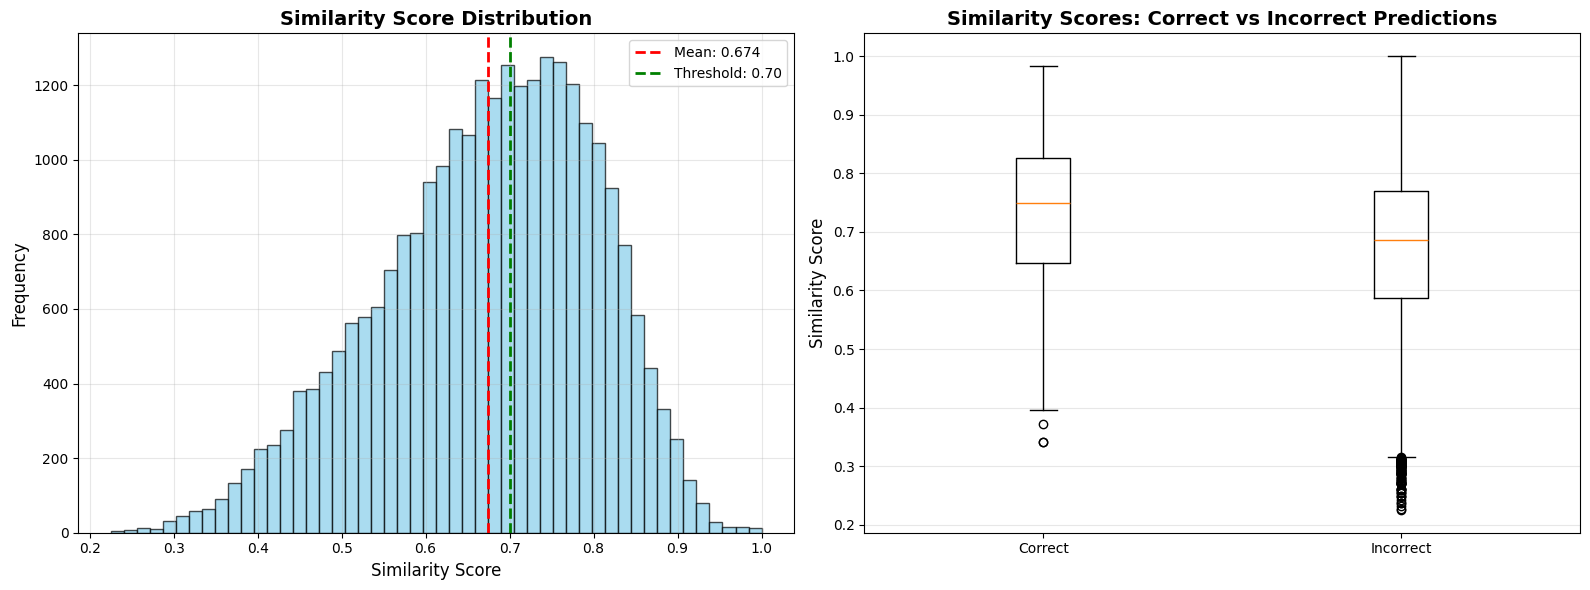


 Correct predictions - Mean: 0.7299, Std: 0.1244
Incorrect predictions - Mean: 0.6725, Std: 0.1283


In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].hist(similarity_scores, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
axes[0].axvline(np.mean(similarity_scores), color='red', linestyle='--', 
                linewidth=2, label=f'Mean: {np.mean(similarity_scores):.3f}')
axes[0].axvline(0.70, color='green', linestyle='--', 
                linewidth=2, label='Threshold: 0.70')
axes[0].set_xlabel('Similarity Score', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Similarity Score Distribution', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

correct_predictions = similarity_scores[predicted_topics == true_topics]
print(predicted_topics, true_topics)
incorrect_predictions = similarity_scores[predicted_topics != true_topics]

data_to_plot = [correct_predictions, incorrect_predictions]
axes[1].boxplot(data_to_plot, labels=['Correct', 'Incorrect'])
axes[1].set_ylabel('Similarity Score', fontsize=12)
axes[1].set_title('Similarity Scores: Correct vs Incorrect Predictions', fontsize=14, fontweight='bold')
axes[1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('docs/similarity_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n Correct predictions - Mean: {correct_predictions.mean():.4f}, Std: {correct_predictions.std():.4f}")
print(f"Incorrect predictions - Mean: {incorrect_predictions.mean():.4f}, Std: {incorrect_predictions.std():.4f}")


In [ ]:
opinions_with_matches = opinions_df.copy()
opinions_with_matches['matched_topic_id'] = results['matched_topic_ids']
opinions_with_matches['similarity_score'] = results['similarity_scores']
opinions_with_matches['is_correct'] = opinions_with_matches['matched_topic_id'] == opinions_with_matches['topic_id']

opinions_with_matches.to_csv('data/processed/opinions_with_matches.csv', index=False)

print(f"\n Results saved to data/processed/opinions_with_matches.csv")

# Summary statistics
print("\n" + "="*70)
print("FINAL SUMMARY")
print("="*70)
print(f"Total opinions processed: {len(opinions_with_matches)}")
print(f"Correct matches: {opinions_with_matches['is_correct'].sum()}")
print(f"Accuracy: {opinions_with_matches['is_correct'].mean():.4f}")
print(f"Average similarity: {opinions_with_matches['similarity_score'].mean():.4f}")


 Results saved to data/processed/opinions_with_matches.csv

FINAL SUMMARY
Total opinions processed: 26690
Correct matches: 596
Accuracy: 0.0223
Average similarity: 0.6738
